In [7]:
import sys
import os
# Get the current working directory
current_dir = os.getcwd()

# Add the src directory to the Python path
src_path = os.path.join(os.path.dirname(current_dir), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import os
import cv2
from GridMetrics import GridScorer, circle_mask, get_even_odd_times, GridParameters, create_new_result_dir, load_grid_metrics_from_pickle
import json
import matplotlib
from matplotlib.lines import Line2D
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
rat = 'r1'
mod = '2'

G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)

Directory c:\Users\acostamendoza\projects\Robust-Grid-Cell-Variability\Variability analysis\results\r12 already exists


# Figure 2A: Overview of standard procedure


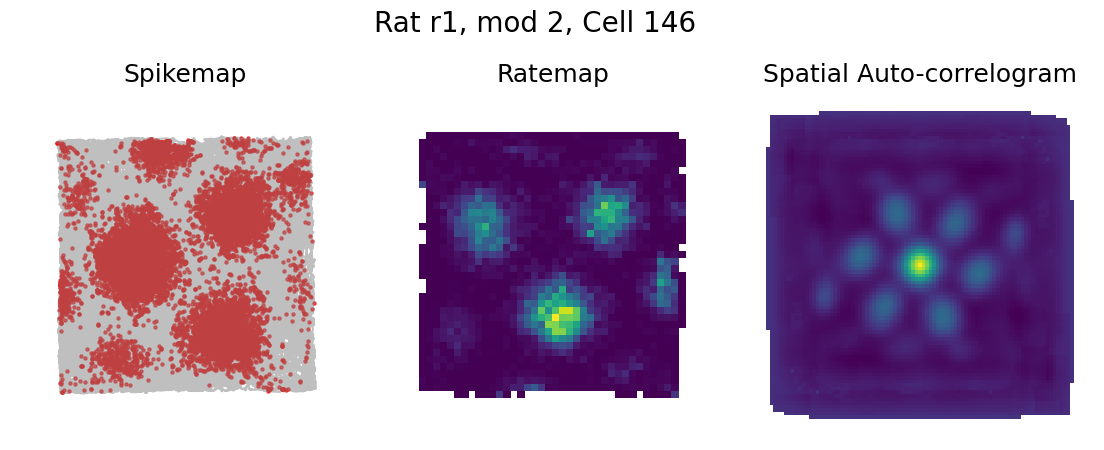

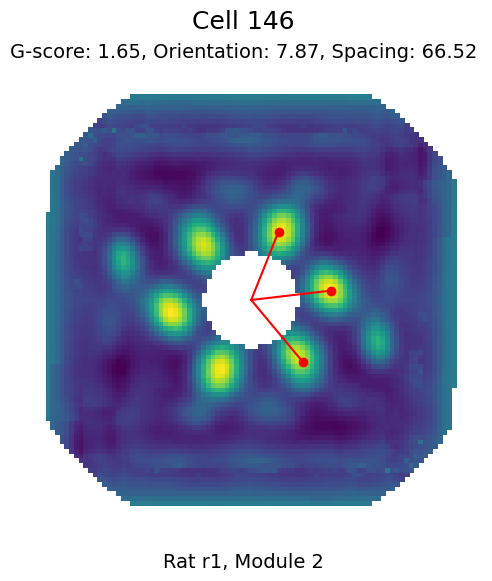

In [18]:
cell = 146

ratemap = G.Scorer.calculate_ratemap(cell = cell)
mask = G.Scorer.get_ring_mask(G.mask_radius, 1)
sac = G.Scorer.calculate_sac(cell)

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
# set figure title
fig.suptitle('Rat ' + str(rat) +', mod ' + mod + ', Cell {}'.format(cell), fontsize = 20)
# bring figure closer to title
fig.subplots_adjust(top=1)
# have less space between subplots
fig.subplots_adjust(wspace=0.05)

axes[0].plot( G.x,  G.y, color='grey', alpha=0.5)
axes[0].scatter(G.x[G.spikes[cell] != 0], G.y[G.spikes[cell] != 0], color='red', alpha=0.7, s=5)
axes[0].set_xlim(-1, 1)
axes[0].set_ylim(-1, 1)
axes[0].set_title('Spikemap', fontsize = 18)

axes[1].pcolor(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), ratemap)
axes[1].set_title('Ratemap', fontsize = 18)

masked_sac = np.ma.masked_where(sac == 0, sac)
cmap = matplotlib.colormaps['viridis']
cmap.set_bad(color='white')
axes[2].imshow(masked_sac)

axes[2].set_title('Spatial Auto-correlogram', fontsize = 18)

for ax in axes:
    ax.set_aspect('equal')
    ax.axis('off')

G.show_orientation_and_spacing(146)

# Figure 1B: Example grid cells from the same module

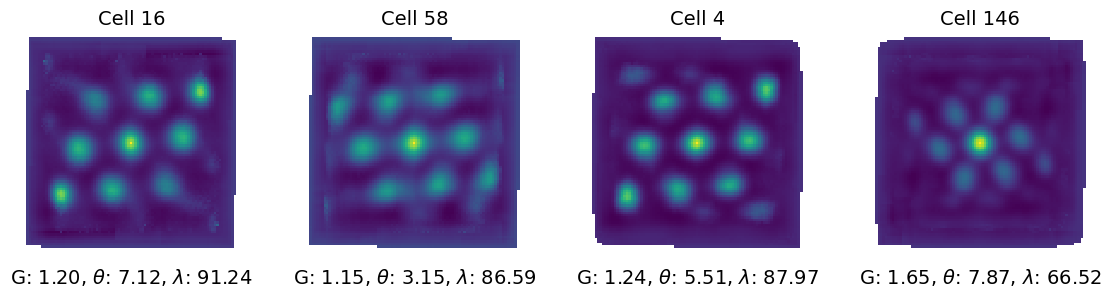

In [20]:
# cell 48 has orientation of 4.29, G = 1.22
# cell 65 has orientation of 7.47, G = 1.23

fig, axes = plt.subplots(1, 4, figsize=(14, 6))
# cells = [83, 58, 8, 128]
cells = [16, 58, 4, 146]

for i, cell in enumerate(cells):
    # sac = G.Scorer.calculate_sac(cell) * G.Scorer.get_ring_mask(G.mask_radius, 1)
    sac = G.Scorer.calculate_sac(cell)
    grid_score = G.grid_scores[cell]
    orientation = G.orientation[cell]
    spacing = G.spacing[cell]

    x_three, y_three = G.get_coordinates_first_3_peaks(sac, polar=False)
    xx, yy = np.meshgrid(np.linspace(-1, 1, 99), np.linspace(-1, 1, 99))
    
    masked_sac = np.ma.masked_where(sac == 0, sac)
    cmap = matplotlib.colormaps['viridis']
    cmap.set_bad(color='white')
    ax = axes[i]
    ax.pcolor(xx, yy, masked_sac, cmap = cmap)
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_aspect('equal', 'box')
    ax.axis('off')

    ax.text(0.0, -1.2, r'G: {:.2f}, $\theta$: {:.2f}, $\lambda$: {:.2f}'
                 .format(grid_score, orientation, spacing), horizontalalignment="center",
                 fontsize=14)
    ax.text(0.0, 1, 'Cell ' + str(cell), horizontalalignment="center", fontsize=14)

# Figure 1C-D: Overlay to show the difference

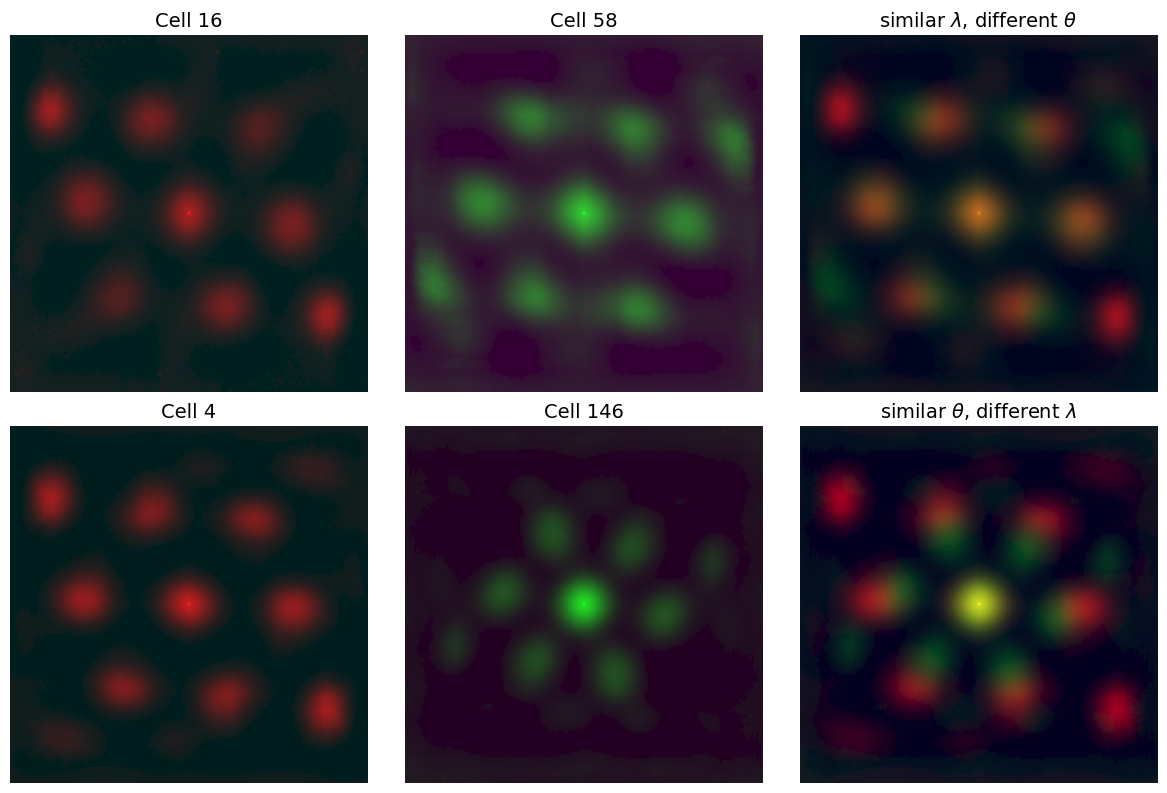

In [22]:
sacs = []
n_bins = 100

for cell in cells:
    # sacs.append(G.Scorer.calculate_sac(cell, bins=n_bins) * G.Scorer.get_ring_mask(G.mask_radius, 1, bins=n_bins))
    sacs.append(G.Scorer.calculate_sac(cell, bins=n_bins))

image_1 = np.dstack((sacs[0],np.zeros_like(sacs[0]),np.zeros_like(sacs[0])))[25:-25, 25:-25, :]
# normalize to 0-1
image_1 = (image_1 - image_1.min()) / (image_1.max() - image_1.min())
image_1[image_1<0.05] = 0

image_2 = np.dstack((np.zeros_like(sacs[1]),sacs[1],np.zeros_like(sacs[1])))[25:-25, 25:-25, :]
image_2 = (image_2 - image_2.min()) / (image_2.max() - image_2.min())
image_2[image_2<0.05] = 0

image_3 = np.dstack((sacs[2], np.zeros_like(sacs[2]),np.zeros_like(sacs[2])))[25:-25, 25:-25, :]
image_3 = (image_3 - image_3.min()) / (image_3.max() - image_3.min())
image_3[image_3<0.05] = 0

image = image_1 + image_2 + image_3

image_4 = np.dstack((np.zeros_like(sacs[3]),sacs[3],np.zeros_like(sacs[3])))[25:-25, 25:-25, :]
image_4 = (image_4 - image_4.min()) / (image_4.max() - image_4.min())
image_4[image_4<0.05] = 0

image = image_1 + image_2 + image_3

image_to_plot = [image_1, image_2, image, image_3, image_4, image_3 + image_4]

# Create a subplot with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, im in enumerate(image_to_plot):
    # scale im to be between 0 and 1
    im = (im - im.min()) / (im.max() - im.min())

    image_8bit = cv2.normalize(im, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    gray_image = cv2.cvtColor(image_8bit, cv2.COLOR_BGR2GRAY)
    fig_name = '/B_example_sacs_2_no_hole_' + str(i+1) + '.png'
    # cv2.imwrite(fig_directory + fig_name, gray_image)

    axes[i].axis('off')
    axes[i].imshow(im)
    
    # Add titles to the subplots
    if i == 0:
        axes[i].set_title(f'Cell {cells[0]}', fontsize=14)
    elif i == 1:
        axes[i].set_title(f'Cell {cells[1]}', fontsize=14)
    elif i == 2:
        axes[i].set_title(r"similar $\lambda$, different $\theta$", fontsize=14)
    elif i == 3:
        axes[i].set_title(f'Cell {cells[2]}', fontsize=14)
    elif i == 4:
        axes[i].set_title(f'Cell {cells[3]}', fontsize=14)
    elif i == 5:
        axes[i].set_title(r"similar $\theta$, different $\lambda$", fontsize=14)

plt.tight_layout()
plt.show()

# Figure 1E: Distribution for orientation

103
103


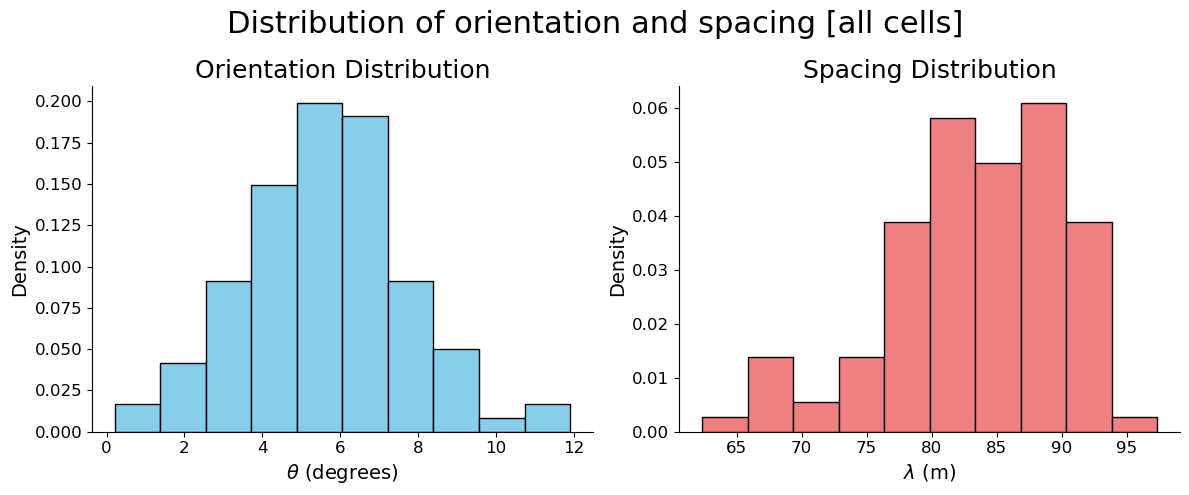

In [ ]:
# Filter out 'None' entries from the data
filtered_orientation = [x for x in G.orientation if x is not None]
filtered_spacing = [x for x in G.spacing if x is not None]
print(len(filtered_spacing))
print(len(filtered_orientation))

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# increase space with title
fig.subplots_adjust(top=0.85)
fig.suptitle('Distribution of orientation and spacing [all cells]', fontsize=22)

# Plot histogram for the original data
axes[0].hist(filtered_orientation, bins=10, color='skyblue', edgecolor='black', density = True)
axes[0].set_xlabel(r'$\theta$ (degrees)')
axes[0].set_ylabel('Density')
axes[0].set_title('Orientation Distribution', fontsize = 18)

# Plot histogram for the filtered data (excluding None entries)
axes[1].hist(filtered_spacing, bins=10, color='lightcoral', edgecolor='black', density = True)
axes[1].set_xlabel(r'$\lambda$ (m)')
axes[1].set_ylabel('Density')
axes[1].set_title('Spacing Distribution', fontsize=18)

# set all labels to fontsize 14
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# Figure 1F: Distribution for spacing

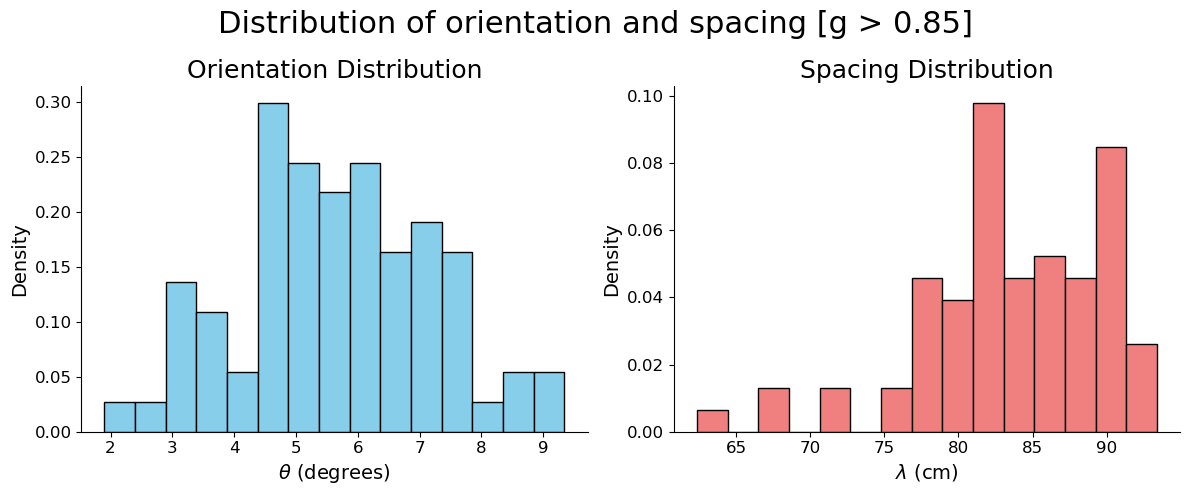

In [27]:
# Filter out 'None' entries from the data
good_cells = np.array(G.grid_scores) > 0.85
filtered_orientation = [x for x in np.array(G.orientation)[good_cells] if x is not None]
filtered_spacing = [x for x in np.array(G.spacing)[good_cells] if x is not None]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# increase space with title
fig.subplots_adjust(top=0.85)
fig.suptitle('Distribution of orientation and spacing [g > 0.85]', fontsize=22)

# Plot histogram for the original data
axes[0].hist(filtered_orientation, bins=15, color='skyblue', edgecolor='black', density = True)
axes[0].set_xlabel(r'$\theta$ (degrees)')
axes[0].set_ylabel('Density')
axes[0].set_title('Orientation Distribution', fontsize = 18)

# Plot histogram for the filtered data (excluding None entries)
axes[1].hist(filtered_spacing, bins=15, color='lightcoral', edgecolor='black', density = True)
axes[1].set_xlabel(r'$\lambda$ (cm)')
axes[1].set_ylabel('Density')
axes[1].set_title('Spacing Distribution', fontsize=18)

# set all labels to fontsize 14
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Adjust spacing between subplots
plt.tight_layout()

# Taking the stats of the distributions

In [28]:
# count the cells with orientation and spacing
print('Number of cells with orientation: ', len(filtered_orientation))

orientation_25th = np.percentile(filtered_orientation, 25)
print('25th percentile of orientation: ', orientation_25th)
orientation_75th = np.percentile(filtered_orientation, 75)
print('75th percentile of orientation: ', orientation_75th)

spacing_25th = np.percentile(filtered_spacing , 25)
print('25th percentile of spacing: ', 100 * spacing_25th)
spacing_75th = np.percentile(filtered_spacing, 75)
print('75th percentile of spacing: ', 100 * spacing_75th)

Number of cells with orientation:  74
25th percentile of orientation:  4.662677547271285
75th percentile of orientation:  6.665462747009945
25th percentile of spacing:  8068.692838051273
75th percentile of spacing:  8896.414513655842


In [29]:
# mean and std of orientation and spacing 
print('Mean orientation: ', np.mean(filtered_orientation))
print('Std orientation: ', np.std(filtered_orientation))

print('Mean spacing: ', np.mean(filtered_spacing))
print('Std spacing: ', np.std(filtered_spacing))

Mean orientation:  5.65925247653894
Std orientation:  1.5631221612580293
Mean spacing:  83.64026439401249
Std spacing:  6.247023969605841
